In [55]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [56]:
#load the Tensorflow - Model weights
network = cv2.dnn.readNetFromTensorflow("graph_opt.pb")

In [57]:
inWidth = 368
inHeight = 368
threshold = 0.2

In [58]:
#got from COCO Data - https://github.com/opencv/opencv/blob/master/samples/dnn/openpose.py
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

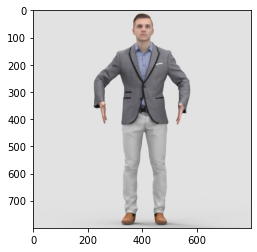

In [59]:
#load and plot the image
img = cv2.imread("test_image.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [60]:
def pose_estimation(frame):
    frame_width = frame.shape[1]
    frame_height = frame.shape[0]
    #blobFromImage - prepare Input for pretrained models
    #args - image, scaling factor, input size - definet by the NN, RGB subtraction values, swap the R and B channel...open cv assumes images in BGR order
    network.setInput(cv2.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    output = network.forward()
    #change output shape from (1, 57, 46, 46) to (1, 19, 46, 46)
    output = output[:, :19, :, :]
    
    #list for detected points
    points = []
    
    for i in range(len(BODY_PARTS)):
        heatmap = output[0, i, :, :]
        
        _, conf, _, point = cv2.minMaxLoc(heatmap)
        
        x = (frame_width * point[0]) / output.shape[3]
        y = (frame_height * point[1]) / output.shape[2]
        
        #use detected points if threshold is reached
        if conf > threshold:
            points.append((int(x), int(y)))
        else:
            pass

    for pair in POSE_PAIRS:
        
        #compare detected body parts with body pairs
        body_part_from = pair[0]
        body_part_to = pair[1]

        body_id_from = BODY_PARTS[body_part_from] 
        body_id_to = BODY_PARTS[body_part_to]

        #connect the detected body parts with lines
        if points[body_id_from] and points[body_id_to]:
            cv2.line(frame, points[body_id_from], points[body_id_to], (0, 255, 0), 3)
            cv2.ellipse(frame, points[body_id_from], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)
            cv2.ellipse(frame, points[body_id_to], (3, 3), 0, 0, 360, (0, 0, 255), cv2.FILLED)
    
    return frame

In [61]:
test = pose_estimation(img)

In [62]:
cv2.imwrite('savedImage.jpg', test)

True